In [1]:
! pip install segmentation-models-pytorch
! pip install -U git+https://github.com/albumentations-team/albumentations
! pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.4 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9d0dddaf16b4e7cf673b354fd841fd4b951c73441744fc73d29a2c7ea384dcfa
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=4bcac763b81838016b3c96005f40a056e829ee8a2f3d9e87822cc883ffaf7869
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientn

In [2]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [4]:
from tqdm import tqdm
from pathlib import Path
import concurrent.futures
import tifffile
import matplotlib.pyplot as plt

In [5]:
DATA_DIR = '../input/deepglobe-land-cover-classification-dataset'
IMG_SIZE = 256

In [6]:
metadata_df = pd.read_csv(Path(DATA_DIR) / 'metadata.csv')

metadata_df = metadata_df[metadata_df['split'] == 'train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]

metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: str(Path(DATA_DIR) / img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: str(Path(DATA_DIR) / img_pth))

metadata_df.head()

,image_id,sat_image_path,mask_path
0,100694,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
1,102122,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
2,10233,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
3,103665,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
4,103730,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...


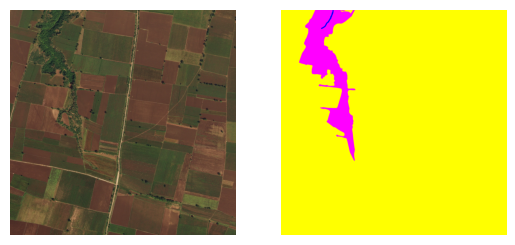

In [7]:
for image, mask in metadata_df[['sat_image_path', 'mask_path']].head(4).values:
    image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('Off')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('Off')
plt.show()

In [8]:
class_dict = pd.read_csv(Path(DATA_DIR) / 'class_dict.csv')
class_dict

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


In [9]:
incorrect_segm_maps = set([
    '271941_sat.jpg', '730821_sat.jpg', '256189_sat.jpg', '925382_sat.jpg', '458776_sat.jpg',
    '705728_sat.jpg', '33573_sat.jpg', '943463_sat.jpg', '898741_sat.jpg', '715633_sat.jpg',
    '127976_sat.jpg', '541353_sat.jpg', '615420_sat.jpg', '614561_sat.jpg', '516317_sat.jpg',
    '626208_sat.jpg', '751939_sat.jpg', '952430_sat.jpg', '622733_sat.jpg', '870705_sat.jpg',
    '897901_sat.jpg', '682046_sat.jpg', '904606_sat.jpg', '286339_sat.jpg', '749375_sat.jpg',
    '483506_sat.jpg', '834433_sat.jpg', '253691_sat.jpg', '418261_sat.jpg', '387018_sat.jpg',
    '565914_sat.jpg', '7791_sat.jpg', '139482_sat.jpg', '141685_sat.jpg', '362191_sat.jpg',
    '496948_sat.jpg', '507241_sat.jpg', '470446_sat.jpg', '641771_sat.jpg', '10452_sat.jpg',
    '351271_sat.jpg', '318338_sat.jpg', '548686_sat.jpg', '763075_sat.jpg', '127660_sat.jpg',
    '232373_sat.jpg', '350033_sat.jpg', '834900_sat.jpg', '471930_sat.jpg', '987427_sat.jpg',
    '34330_sat.jpg', '585043_sat.jpg', '254565_sat.jpg', '533948_sat.jpg', '605707_sat.jpg',
    '412210_sat.jpg', '419820_sat.jpg', '21717_sat.jpg', '185562_sat.jpg', '556572_sat.jpg',
    '244423_sat.jpg', '617844_sat.jpg', '651537_sat.jpg', '899693_sat.jpg', '864488_sat.jpg',
    '850510_sat.jpg', '309818_sat.jpg', '991758_sat.jpg', '331533_sat.jpg', '125510_sat.jpg',
    '123172_sat.jpg', '949559_sat.jpg', '858771_sat.jpg', '629198_sat.jpg', '2334_sat.jpg',
    '503968_sat.jpg'])

In [10]:
pwd = Path().cwd()
(pwd / 'water').mkdir()
(pwd / 'no_water').mkdir()

In [11]:
def label_water(mask: np.array) -> np.array:
    water_mask = [
        (mask[:, :, 0] == 0).astype(np.uint8),
        (mask[:, :, 1] == 0).astype(np.uint8),
        (mask[:, :, 2] == 255).astype(np.uint8)
    ]
    water_mask = water_mask[0] + water_mask[1] + water_mask[2]
    water_mask = (water_mask == 3).astype(np.uint8)
    water_mask = water_mask[..., np.newaxis]
    return water_mask

In [12]:
def process_sample(image_path, mask_path):
    image_filename = Path(image_path).name

    if image_filename in incorrect_segm_maps:
        return
    
    image_filename = image_filename.replace('sat', 'image').replace('jpg', 'tif')
    mask_filename = Path(mask_path).name
    
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

    binary_mask = label_water(mask)

    out_dir = 'water' if np.sum(binary_mask) > 0 else 'no_water'

    image_out_path = str(pwd / out_dir / image_filename)
    mask_out_path = str(pwd / out_dir / mask_filename)
    
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)[:, :, :3]
    binary_mask = cv2.resize(binary_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    
    tifffile.imwrite(image_out_path, image, photometric='rgb')
    cv2.imwrite(mask_out_path, binary_mask)

In [13]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(process_sample, image_path, mask_path) for image_path, mask_path in metadata_df[['sat_image_path', 'mask_path']].values]

In [14]:
DATA_DIR = '/kaggle/input/landcoverai'
IMG_SIZE = 256

In [15]:
img_subdir = Path(DATA_DIR) / 'images'
mask_subdir = Path(DATA_DIR) / 'masks'

In [16]:
image_paths = list(img_subdir.glob('*tif'))
mask_paths = [mask_subdir / path.name for path in image_paths]

image_paths = [str(path) for path in image_paths]
mask_paths = [str(path) for path in mask_paths]

In [17]:
class_id = {
    'Background': 0,
    'Building': 1,
    'Woodland': 2,
    'Water': 3,
    'Road': 4
}

In [18]:
def label_water(mask: np.array) -> np.array:
    water_mask = (mask == 3).astype(np.uint8)
    water_mask = water_mask[..., np.newaxis]
    return water_mask

In [19]:
def process_sample(image_path, mask_path):
    image = tifffile.imread(image_path)
    mask = tifffile.imread(mask_path)

    binary_mask = label_water(mask)

    image_filename = f'{Path(image_path).stem}_image.tif'
    mask_filename = f'{Path(mask_path).stem}_mask.png'

    out_dir = 'water' if np.sum(binary_mask) > 0 else 'no_water'
    
    image_out_path = str(pwd / out_dir / image_filename)
    mask_out_path = str(pwd / out_dir / mask_filename)
    
    tifffile.imwrite(image_out_path, image, photometric='rgb')
    cv2.imwrite(mask_out_path, binary_mask)

In [20]:
n_samples = len(image_paths)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(process_sample, image_paths[i], mask_paths[i]) for i in range(n_samples)]

In [21]:
water_images = list((pwd / 'water').glob('*tif'))
water_images = [str(path) for path in water_images]
water_masks = [path.replace('image', 'mask').replace('tif', 'png') for path in water_images]

n_water_samples = len(water_images)
print(f'Total number of water images: {n_water_samples}')

Total number of water images: 442


In [22]:
import os

In [23]:
images_list = sorted(water_images)
masks_list = sorted(water_masks)

df = pd.DataFrame({'images': images_list, 
                   'masks': masks_list})

df.head()

,images,masks
0,/kaggle/working/water/102122_image.tif,/kaggle/working/water/102122_mask.png
1,/kaggle/working/water/10233_image.tif,/kaggle/working/water/10233_mask.png
2,/kaggle/working/water/103665_image.tif,/kaggle/working/water/103665_mask.png
3,/kaggle/working/water/10901_image.tif,/kaggle/working/water/10901_mask.png
4,/kaggle/working/water/111335_image.tif,/kaggle/working/water/111335_mask.png


In [24]:
df.shape

(442, 2)

In [25]:
DATA_DIR = '/kaggle/working/'

DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')

EPOCHS = 10
LR = 0.003
IMAGE_SIZE = 256
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b6'
WEIGHTS = 'imagenet'

In [26]:
index = 228
row = df.iloc[index]

image_path = row.images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask_path = row.masks
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

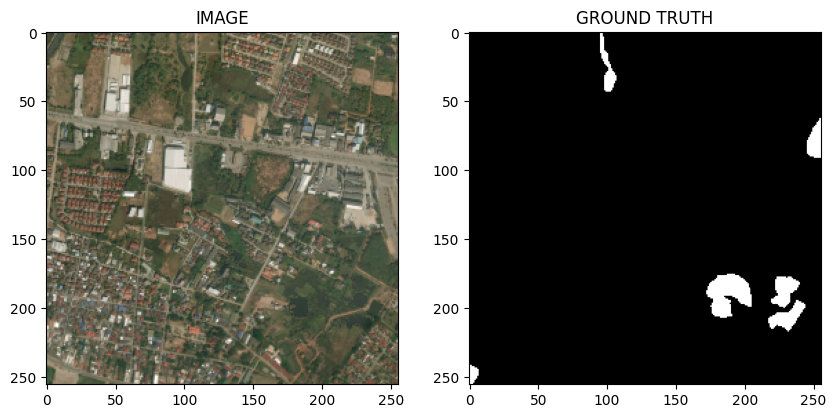

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [28]:
train_df, val_df = train_test_split(df, test_size=0.2)

In [29]:
import albumentations as A

In [30]:
def get_train_augs():
    return A.Compose([A.Resize(IMAGE_SIZE, 
                               IMAGE_SIZE, 
                               always_apply=True),
                      A.HorizontalFlip(p=0.5),
                      A.VerticalFlip(p=0.5)],
                     is_check_shapes=False)


def get_val_augs():
    return A.Compose([A.Resize(IMAGE_SIZE, 
                               IMAGE_SIZE, 
                               always_apply=True)],
                     is_check_shapes=False)

In [31]:
from torch.utils.data import Dataset

In [32]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = df.iloc[index]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image= np.transpose(image, (2, 0, 1))
        mask= np.transpose(mask, (2, 0, 1))

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask) / 255.0

        return image, mask

In [33]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(val_df, get_val_augs())

In [34]:
print(f"Size of Trainset: {len(trainset)}")
print(f"Size of Validset: {len(validset)}")

Size of Trainset: 353
Size of Validset: 89


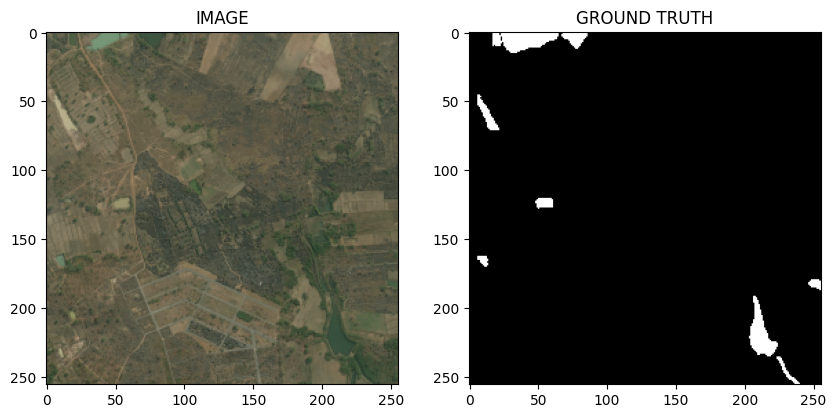

In [35]:
idx = 42

image, mask = trainset[idx]
show_image(image, mask)

In [36]:
from torch.utils.data import DataLoader

In [37]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [38]:
print(f'Total number of batches in trainloader: {len(trainloader)}')
print(f'Total number of batches in validloader: {len(validloader)}')

Total number of batches in trainloader: 23
Total number of batches in validloader: 6


In [39]:
for image, mask in trainloader:
    break
    
print(f'One batch image shape {image.shape}')
print(f'One batch mask shape {mask.shape}')

One batch image shape torch.Size([16, 3, 256, 256])
One batch mask shape torch.Size([16, 1, 256, 256])


In [40]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [41]:
class SegmentationModel(nn.Module):
    
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.arc = smp.UnetPlusPlus(encoder_name=ENCODER, # попробовать DeepLabV3Plus с b4
                                     encoder_weights=WEIGHTS,
                                     in_channels=3,
                                     classes=1,
                                     activation=None
                                    )
        
    def forward(self, images, masks=None):
        logits = self.arc(images)
        
        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            
            return logits, loss1 + loss2

        return logits

In [42]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b6_aa-80ba17e4.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b6_aa-80ba17e4.pth
100%|██████████| 165M/165M [00:00<00:00, 251MB/s]  


SegmentationModel(
  (arc): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (bn1): BatchNormAct2d(
              56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
 

In [43]:
! pip install torchsummary

In [44]:
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 56, 128, 128]           1,512
          Identity-2         [-1, 56, 128, 128]               0
             Swish-3         [-1, 56, 128, 128]               0
    BatchNormAct2d-4         [-1, 56, 128, 128]             112
            Conv2d-5         [-1, 56, 128, 128]             504
          Identity-6         [-1, 56, 128, 128]               0
             Swish-7         [-1, 56, 128, 128]               0
    BatchNormAct2d-8         [-1, 56, 128, 128]             112
            Conv2d-9             [-1, 14, 1, 1]             798
            Swish-10             [-1, 14, 1, 1]               0
           Conv2d-11             [-1, 56, 1, 1]             840
          Sigmoid-12             [-1, 56, 1, 1]               0
    SqueezeExcite-13         [-1, 56, 128, 128]               0
           Conv2d-14         [-1, 32, 1

In [45]:
def train_net(dataloader, model, optimizer):
    model.train()
    
    total_loss = 0.0
    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [46]:
def eval_net(dataloader, model):
    model.eval()
    
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            logits, loss = model(images, masks)
            total_loss += loss.item()
            
    return total_loss / len(dataloader)

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [48]:
best_valid_loss = np.Inf

for i in range (EPOCHS):
    train_loss = train_net(trainloader, model, optimizer)
    valid_loss = eval_net(validloader, model)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("Model saved")
        best_valid_loss = valid_loss
    
    print(f'Epoch: {i+1}, Training Loss: {train_loss}, Validation Loss: {valid_loss}')

100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


Model saved
Epoch: 1, Training Loss: 1.2520511409510737, Validation Loss: 1.030243198076884


100%|██████████| 6/6 [00:01<00:00,  4.24it/s]


Model saved
Epoch: 2, Training Loss: 1.0180192512014639, Validation Loss: 1.0115155776341755


100%|██████████| 6/6 [00:01<00:00,  4.23it/s]


Model saved
Epoch: 3, Training Loss: 1.0068492682083794, Validation Loss: 1.0050843159357707


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


Model saved
Epoch: 4, Training Loss: 1.003864666689997, Validation Loss: 1.0032271544138591


100%|██████████| 6/6 [00:01<00:00,  4.16it/s]


Model saved
Epoch: 5, Training Loss: 1.0021327889483909, Validation Loss: 1.001937468846639


100%|██████████| 6/6 [00:01<00:00,  4.12it/s]


Model saved
Epoch: 6, Training Loss: 1.0009177819542263, Validation Loss: 1.0010758936405182


100%|██████████| 6/6 [00:01<00:00,  4.15it/s]


Epoch: 7, Training Loss: 1.0002543563428132, Validation Loss: 1.001730779806773


100%|██████████| 6/6 [00:01<00:00,  4.18it/s]


Model saved
Epoch: 8, Training Loss: 0.9998607713243236, Validation Loss: 1.0001115600268047


100%|██████████| 6/6 [00:01<00:00,  4.16it/s]


Model saved
Epoch: 9, Training Loss: 0.9986429033072098, Validation Loss: 0.9994877874851227


100%|██████████| 6/6 [00:01<00:00,  4.14it/s]


Model saved
Epoch: 10, Training Loss: 0.9986004881236864, Validation Loss: 0.9990362823009491


In [49]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

<All keys matched successfully>

In [50]:
test_path = '/kaggle/input/rucode-4-dataset/RuCode_2024_Start_Water_Segm/public_test/public_test/images'

test_list = sorted([os.path.join(test_path, file) for file in os.listdir(test_path) if file.endswith('.tif')])

test_df = pd.DataFrame({'images': test_list, 
                        'masks': test_list})

test_df.head()

,images,masks
0,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...
1,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...
2,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...
3,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...
4,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...


In [51]:
test_path = '/kaggle/input/rucode-4-dataset/RuCode_2024_Start_Water_Segm/public_test/public_test/images'

test_list = sorted([os.path.join(test_path, file) for file in os.listdir(test_path) if file.endswith('.tif')])

df = pd.DataFrame({'images': test_list, 
                   'masks': test_list})

df.head()

,images,masks
0,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...
1,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...
2,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...
3,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...
4,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...,/kaggle/input/rucode-4-dataset/RuCode_2024_Sta...


In [52]:
testset = SegmentationDataset(test_df, get_val_augs())

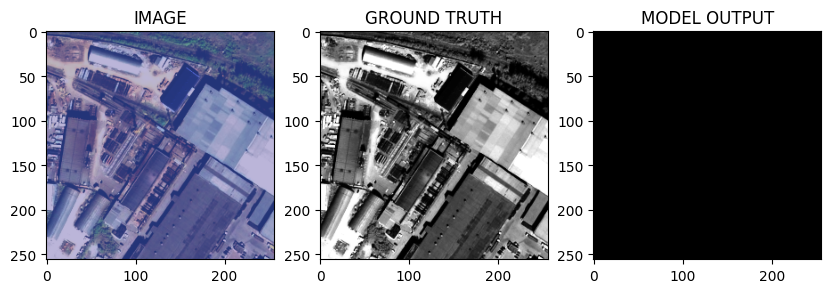

In [53]:
image, mask = testset[333]
logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.09) * 1.0

show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [54]:
from torchvision.utils import save_image

for thold in (0.09,):

    if not os.path.exists(f'/kaggle/working/predictions_{thold}'):
        os.makedirs(f'/kaggle/working/predictions_{thold}')

    for index in range(784):
        curr_name = test_df.images[index].split('/')[-1]
        
        image, mask = testset[index]
        logits_mask = model(image.to(DEVICE).unsqueeze(0))

        pred_mask = torch.sigmoid(logits_mask)
        pred_mask = (pred_mask > thold) * 1.0

        save_image(pred_mask, f'/kaggle/working/predictions_{thold}/{curr_name}')
        
    path_to_dir = f'/kaggle/working/predictions_{thold}'

    files = os.listdir(path_to_dir)

    prefix = 'public_test_'
    filenames = [prefix + f'{i+1}.tif' for i in range(784)]

    assert len(filenames) == 784, f'Length of test set is {len(filenames)} not equal 784! Please check test images'

    def read_image_as_tensor(file_path):
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        tensor = np.array(image, dtype=np.bool_)

        return tensor

    tensor_list = []

    for filename in filenames:
        file_path = os.path.join(path_to_dir, filename)
        tensor = read_image_as_tensor(file_path)
        tensor_list.append(tensor)

    tensor_array = np.array(tensor_list)

    print('Размерность тензора:', tensor_array.shape)

    assert tensor_array.shape == (784, 256, 256), 'Please check path to images'

    output_file = f'solution_{thold}.npy'

    np.save(output_file, tensor_array)

Размерность тензора: (784, 256, 256)


In [55]:
# 0.09 -> 91.45476 # 10 эпох на deepglobe и landcoverai